In [8]:
#Importerte biblioteker
import os
import sys
import pandas as pd
from pandasql import sqldf
from dotenv import load_dotenv
from sklearn.preprocessing import PowerTransformer

#Globale parametrere for frostAPI
load_dotenv()
client_id = os.getenv('client_id_frost') #henter unik id fra .env fil
from_date = "2010-04-02"
to_date = "2016-12-30"


In [9]:
#Spesiell funskjon for å bruke generell frostAPI funksjon for hente værdata 
def data_frostAPI():
    endpoint = "https://frost.met.no/observations/v0.jsonld"
    parameters = {
        "sources": "SN18700", #oslo 
        "elements": 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)', #Henter vind, tempratur og nedbør
        "referencetime": "2010-04-02/2016-12-31",  
    }

    file = "../../data/raw_data/frostAPI_data.json"
    elements = {
    "mean(air_temperature P1D)": "Temperatur",
    "sum(precipitation_amount P1D)": "Nedbør",
    "mean(wind_speed P1D)": "Vindhastighet"}
    
    sys.path.insert(0, '../../src/')
    from frostAPI.data_frostAPI import fetch_weather_data_frostAPI
    fetch_weather_data_frostAPI(endpoint, parameters, file, client_id,elements)

data_frostAPI()

Gruppert data er lagret under ../../data/raw_data/frostAPI_data.json


In [10]:
#Spesiell funksjon for å bruke generell funksjon for hente stasjoner fra frostAPI
def get_stations_frostAPI():
    
    parameters = {
        'types': 'SensorSystem',  
        'country': 'NO',      
    }

    endpoint = 'https://frost.met.no/sources/v0.jsonld'

    sys.path.insert(0, '../../src/')
    from frostAPI.data_frostAPI import get_info_frostAPI
    get_info_frostAPI(endpoint, parameters, client_id)

#get_stations_frostAPI()

In [11]:
#Spesiell funksjon for å bruke generell funksjon for hente elementer fra frostAPI
def get_elements_frostAPI():
    
    parameters = None
    endpoint = 'https://frost.met.no/elements/v0.jsonld'

    sys.path.insert(0, '../../src/')
    from frostAPI.data_frostAPI import get_info_frostAPI
    get_info_frostAPI(endpoint, parameters, client_id)

#get_elements_frostAPI()



Outliers for Nedbør:


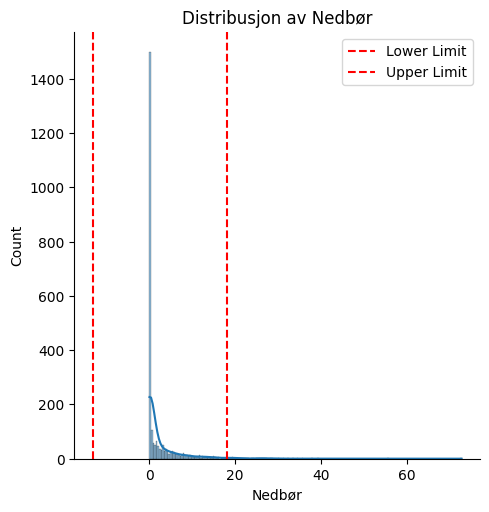


Outliers for Temperatur:


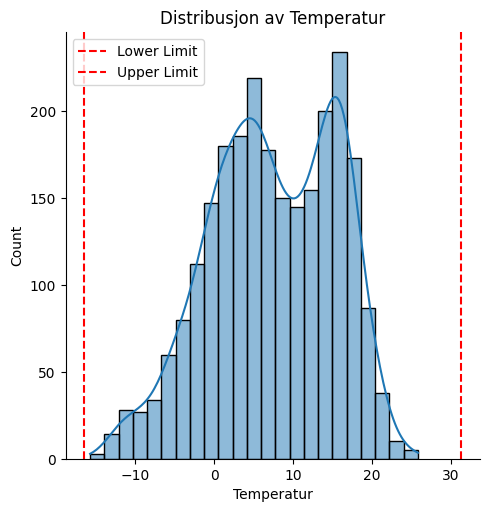


Outliers for Vindhastighet:


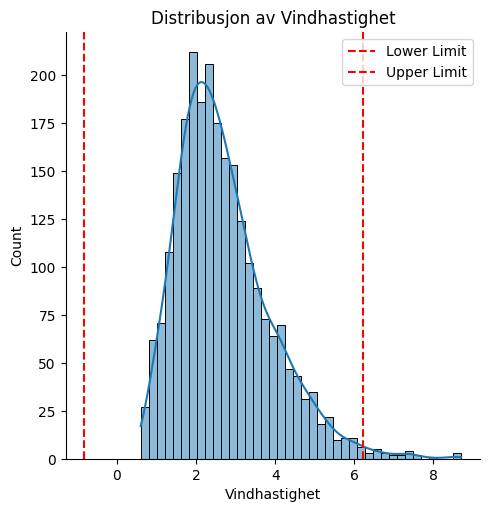

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Les inn JSON-data
df_frost = pd.read_json("../../data/raw_data/frostAPI_data.json")

# Liste over variabler du vil analysere
variabler = ['Nedbør', 'Temperatur', 'Vindhastighet']
threshold = 3

for variabel in variabler:
    # Beregn gjennomsnitt og standardavvik for hver variabel
    mean = df_frost[variabel].mean()
    std = df_frost[variabel].std()
    lower_limit = mean - threshold * std
    upper_limit = mean + threshold * std

    # Finn outliers
    outliers = df_frost[~df_frost[variabel].between(lower_limit, upper_limit)]
    print(f"\nOutliers for {variabel}:")
    print(outliers[[variabel]].count())

    # Lag distribusjonsplot
    plot = sns.displot(data=df_frost, x=variabel, kde=True)
    plot.set(title=f"Distribusjon av {variabel}", xlabel=variabel)

    # Legg til linjer for øvre og nedre grenser
    for ax in plot.axes.flat:
        ax.axvline(lower_limit, color='r', linestyle='--', label='Lower Limit')
        ax.axvline(upper_limit, color='r', linestyle='--', label='Upper Limit')
        ax.legend()

    plt.show()


In [12]:
#funskjon som setter outliers til Nan-verdi og interpolerer Nan-verdier
def clean_data_frostAPI():
    
    sys.path.insert(0, '../../src/')
    from frostAPI.data_frostAPI import remove_outliers_frost_data, interpolate_and_save_clean_data
    raw_data_file = "../../data/raw_data/frostAPI_data.json"
    clean_data_file = "../../data/clean_data/frostAPI_clean_data.json"
    cols =["Nedbør", "Temperatur", "Vindhastighet"]

    no_outliers_df=remove_outliers_frost_data(raw_data_file, cols)
    interpolate_and_save_clean_data(no_outliers_df, clean_data_file, from_date, to_date)
    
clean_data_frostAPI()


Fjerning av outliers:
Outliers er mer enn 3 standardavvik unna gjennomsnittet

Nedbør:
Fjernet 62 outliers
Standardavvik: 5.22
Gjennomsnitt: 2.43

Temperatur:
Fjernet 0 outliers
Standardavvik: 7.95
Gjennomsnitt: 7.43

Vindhastighet:
Fjernet 25 outliers
Standardavvik: 1.18
Gjennomsnitt: 2.71


Interpolering av NaN-verdier:
Nedbør: 62 verdier ble interpolert
Temperatur: 0 verdier ble interpolert
Vindhastighet: 26 verdier ble interpolert

Gruppert data er lagret under ../../data/clean_data/frostAPI_clean_data.json


In [ ]:
#funskjon som skal nomalfordele skjevheten i dataene med yeo-johnson metoden

def fix_skewness_data_frostAPI():
    
    sys.path.insert(0, '../../src/')
    from frostAPI.data_frostAPI import analyse_and_fix_skewness
    clean_data_file = "../../data/clean_data/frostAPI_clean_data.json"
    analyze_data_file= "../../data/analyzed_data/frostAPI_analyzed_data.json"
    threshold = 1.0
    cols =["Nedbør", "Temperatur", "Vindhastighet"]
    analyse_and_fix_skewness(clean_data_file, analyze_data_file, threshold, cols)

fix_skewness_data_frostAPI()


Skjevhet før transformasjon:
→ Nedbør: 2.28
→ Temperatur: -0.27
→ Vindhastighet: 0.71

Påfører Yeo-Johnson på kolonner med skjevhet > ±1.0

Skjevhet etter transformasjon:
→ Nedbør: 0.63
→ Temperatur: -0.27
→ Vindhastighet: 0.71

Gruppert data er lagret under ../../data/analyzed_data/frostAPI_analyzed_data.json


In [ ]:
#månedlig statistikk

df = pd.read_json("../../data/clean_data/frostAPI_clean_data.json")

query = """
SELECT 
    strftime('%Y-%m', Dato) AS Måned, 
    AVG(Temperatur) AS SnittTemp,
    AVG(Nedbør) AS SnittNedbør,
    AVG(Vindhastighet) AS SnittVindhastighet,
    COUNT(*) AS AntallDager
FROM df
GROUP BY Måned
ORDER BY Måned
"""
pysqldf = lambda q: sqldf(q, globals())
månedlig_stats = sqldf(query)
print(månedlig_stats)



      Måned  SnittTemp  SnittNedbør  SnittVindhastighet  AntallDager
0   2010-04   5.910345     1.017241            2.448276           29
1   2010-05  10.822581     0.916129            2.932258           31
2   2010-06  15.350000     1.486667            2.746667           30
3   2010-07  18.009677     2.995161            2.867742           31
4   2010-08  16.183871     3.419355            2.832258           31
..      ...        ...          ...                 ...          ...
76  2016-08  15.490323     4.043548            2.741935           31
77  2016-09  15.140000     0.728333            2.436667           30
78  2016-10   6.206452     0.425806            3.301613           31
79  2016-11   0.890000     2.326667            2.661667           30
80  2016-12   0.690000     0.650000            1.946667           30

[81 rows x 5 columns]
